# Code for fitting Astero RC data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind')
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 
import pandas as pd
import pystan

import os
import pickle

#from omnitool.literature_values import *

import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_data():
#     sfile = '../Data/MRCxyu18.csv'
#     sfile = '../data/KepxDR2/MRCxyu18_wdupes_BC.csv'
    sfile = '../data/KepxDR2/rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))


In [3]:
df = read_data()
print('Size: '+str(len(df)))
df.head(2)

Size: 7534


,KICID,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,BC_GBP,BC_GRP,BC_J,BC_H,BC_K,ast_MKs,ast_MH,ast_MJ,ast_MG,ast_M_err
0,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,...,-0.740,0.388,1.206,1.638,1.766,-1.671046,-1.543046,-1.111046,0.343954,0.206767
1,1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,...,-0.754,0.409,1.252,1.706,1.840,-1.878376,-1.744376,-1.290376,0.205624,0.166498


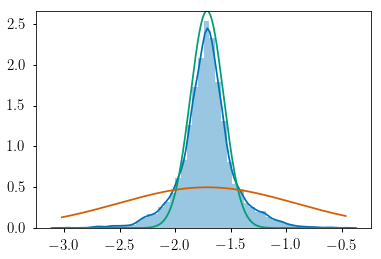

-1.7156176772031073


In [5]:
'''Step one is figuring out the different distributions we want'''
df.head(2)
Ks = df.ast_MKs.values

x = np.linspace(Ks.min(),Ks.max(),1000)

fg = normal(x, np.median(Ks), 0.15)
bg = normal(x, np.median(Ks), .8)

sns.distplot(Ks)
plt.plot(x,fg)
plt.plot(x,bg)
plt.show()

print(np.median(Ks))

## Stan model for asteroseismic values

In [18]:
overwrite = True
asterostan = '''data {
    int<lower = 0> N;
    real M[N];
    real <lower=0> M_err[N];
}

parameters {
    real mu;
    real muo;
    real <lower=0.> sigma;
    real <lower=0.3> sigo;
    real <lower=0.,upper=1.> Q;
    real M_true_std[N];
}
transformed parameters{
    real M_true[N];
    real tmuo;
    real<lower=0.> tsigo;

    for (n in 1:N){
        M_true[n] = mu + sigma * M_true_std[n];
    }
    tmuo = muo - mu;
    tsigo = sigo / sigma;
}
model {
    M ~ normal(M_true, M_err); //Measurement uncertainty
    
    //Parameters in true space
//    mu ~ normal(-1.71, .1);
//    sigma ~ normal(.1, .05);
    Q ~ normal(.95, .1);
//    muo ~ normal(-1.71, .01);
//    sigo ~ normal(1., .1);
    mu ~ uniform(-2., -1.);
    sigma ~ uniform(0.01, 0.3);
//    Q ~ uniform(0., 1.);
    muo ~ normal(mu, .01);
    sigo ~ uniform(.3, 3.);

    //Mixture model (in transformed space)
    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(M_true_std[n] | 0, 1),
            normal_lpdf(M_true_std[n] | muo, tsigo));
}
'''
model_path = 'asterostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL asterostan_1b93d3074af4e62a68d39f36a4763b03 NOW.


Updating Stan model


In [ ]:
sel = df[:1000]
M = sel.ast_MKs.values
M_err = sel.ast_M_err.values
m = sel.kmag
dat = {'N': len(sel),
      'M': M,
      'M_err' : M_err}

init = [{'mu':-1.71,
       'sigma':0.2,
       'Q': 0.95,
       'muo':-1.71,
       'sigo':1.}]

fit = sm.sampling(data=dat, iter=10000, chains=1, init=init)

In [ ]:
fit.plot()
plt.show()

In [ ]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['muo'],fit['sigo']])
corner.corner(chain.T,labels=['mu','sigma','Q','muo','sigo'],\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [ ]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
muo = np.median(fit['muo'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])
M_true = np.median(fit['M_true'],axis=0)


fg = normal(M, mu, sigma)
bg = normal(M, muo, sigo)
L = Q*fg + (1-Q)*bg

In [ ]:
%pylab qt
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])


sax.scatter(M_true,m,s=5,zorder=1000)
sax.errorbar(M_true,m,xerr=M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(M, ax=xax, label='M obs')
sns.distplot(M_true,ax=xax, label='M True')
xax.scatter(M,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(M,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(M, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)
xax.legend()


sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [ ]:
s = fit.summary()

In [ ]:
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

In [ ]:
sys.exit()

## Other useful code

In [ ]:
sns.distplot(Ks[heb])
plt.scatter(Ks,fg,s=3)
sns.distplot(Ks[~heb])
plt.scatter(Ks,bg,s=3)
plt.show()

sns.distplot(Ks)
plt.scatter(Ks,L,s=3)
plt.show()

In [ ]:
sys.exit()


In [ ]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)

recall, precision = [], []
for lim in np.linspace(lnK.min(),lnK.max(),1000):
    mask = lnK > lim
    cheb_correct = len(Ks[mask][stage[mask]==2])
    cheb_total = len(Ks[stage==2])
    identified_total = len(Ks[mask])
    recall.append(float(cheb_correct)/float(cheb_total))
    try:
        precision.append(float(cheb_correct)/float(identified_total))
    except:
        precision.append(0.)
        
fig, ax = plt.subplots()
col = ax.scatter(recall, precision, c=np.linspace(lnK.min(),lnK.max(),1000),vmin=0.)
ax.axhline(0.9,c='r',label='0.9 precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_axisbelow(True)
fig.colorbar(col, label='lnK cut-off point',extend='min')
plt.show()        


In [ ]:
import barbershop
%pylab inline
barber = barbershop.open(df,'ast_MKs','M')
barber.add_client('stage')
barber.add_client('logg')
barber.add_client('M')
barber.histograms_on(x=True, y=True)
barber.show_mirror()

In [ ]:
list(df)
import os
os.path.isfile('../data/KepxDR2/MRCxyu18.csv')

In [ ]:
'''
generated quantities {
    vector[N] post_prob;
    vector[N] bg_pp;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(M_true_std[n] | 0, 1);
        ll_bg = log(1-Q) + normal_lpdf(M_true_std[n] | tmuo, tsigo);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
        bg_pp[n] = exp(ll_bg - log_sum_exp(ll_fg, ll_bg));
    }
}
'''

In [ ]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])

# cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(M,m,s=5,c=post_prob,zorder=1000)
# fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(M,m,xerr=M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(M,ax=xax)

xax.scatter(M,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(M,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(M, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [ ]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)
mask = lnK > 1.

cheb_correct = len(M[mask][sel.stage[mask]==2])
cheb_total = len(M)
identified_total = len(M[mask])
recall = float(cheb_correct)/float(cheb_total)

print('Total stars: '+str(cheb_total))
print('Total IDd as inlier: '+str(cheb_correct))
print('Total rejected: '+str(cheb_total-cheb_correct))
print('This is a '+str((cheb_total-cheb_correct)*100./cheb_total)+'% rejection.')

In [ ]:
fig, (ax,ax2)  = plt.subplots(2,figsize=(10,10))
ax.scatter(M[~mask],m[~mask],s=5,c=post_prob[~mask],zorder=1000, label='Outliers')
fig.colorbar(c,ax=ax, label='Posterior Probability')
ax.errorbar(M[~mask],m[~mask],xerr=M_err[~mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax.scatter(M[mask],m[mask],s=1,alpha=.1,c='r', label='Inliers')
ax.legend()

ax2.scatter(M[mask],m[mask],s=5,c=post_prob[mask],zorder=1000, label='Inliers')
fig.colorbar(c, ax = ax2, label='Posterior Probability')
ax2.errorbar(M[mask],m[mask],xerr=M_err[mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax2.scatter(M[~mask],m[~mask],s=10,alpha=.5,c='r',label='Outliers')
ax2.legend()

ax.set_xlabel('Absmag in K')
ax.set_ylabel('App mag in K')
plt.show()

What the above plot indicates is that inlier stars are defined by uncertainty more than anything else, and that allt he outlier stars have uncertainties that end near a similar limit, whereas the inlier stars can be more spread out, so long as their uncertainties have a chance at placing them at the overdensity.